In [6]:
%load_ext autoreload

%autoreload 2
import sys
import corner
import numpy as np
import matplotlib.pyplot as plt
import scipy
def binning(corner): return [[corner[i],corner[i+1]] for i in range(len(corner)-1)]
sys.path.append('/pbs/throng/lsst/users/cpayerne/LikelihoodsClusterAbundance/modules/')
import covariance as covar
import utils
import pandas as pd
import abundance as cl_count
import forecast
import emcee
from lnlikelihood import lnLikelihood
import pyccl as ccl
import edit
import h5py, glob
Omega_c_true = 0.30711 - 0.048254
Omega_b_true = 0.048254
sigma8_true = .8288
Omegam_true = 0.30711
True_value = [Omega_c_true + Omega_b_true, sigma8_true]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
cosmo = ccl.Cosmology(Omega_c = Omegam_true - 0.048254, Omega_b = 0.048254, 
                              h = 0.6777, sigma8 = sigma8_true, n_s=0.96)

# Data

In [8]:
where_cat = '/sps/lsst/users/cpayerne/1000xsimulations/1000_simulations/afumagalli/catalogs/plc_14/*'
cat = glob.glob(where_cat)

for i ,c in enumerate(cat):
    cat_test = pd.read_csv(c ,sep=' ',skiprows=12, names=['M','z','dec','ra'])
    ra, dec, redshift, Mvir = cat_test['ra'], cat_test['dec'], cat_test['z'], cat_test['M']/0.6777
    if i == 3: break

In [9]:
lnL = lnLikelihood()
clc = cl_count.ClusterAbundance()
clc.sky_area = (1)*4*np.pi
clc.f_sky = clc.sky_area/(4*np.pi)
z_grid = np.linspace(.2, 1, 1000)
logm_grid = np.linspace(14.2, 15.6, 501)

z_corner = np.linspace(.2, 1, 5)
log10m_corner = np.linspace(14.2, 15.6, 11)
Z_bin = [[z_corner[i], z_corner[i+1]] for i in range(len(z_corner)-1)]
LogMass_bin = [[log10m_corner[i], log10m_corner[i+1]] for i in range(len(log10m_corner)-1)]

In [20]:
cosmo = ccl.Cosmology(Omega_c = Omega_c_true + Omega_b_true - 0.048254, Omega_b = 0.048254, 
                          h = 0.6777, sigma8 = sigma8_true, n_s=0.96)
massdef = ccl.halos.massdef.MassDef('vir', 'critical', c_m_relation=None)
hmd = ccl.halos.hmfunc.MassFuncDespali16(cosmo, mass_def=massdef)
halobias = ccl.halos.hbias.HaloBiasTinker10(cosmo, mass_def= massdef, mass_def_strict=True)
clc.set_cosmology(cosmo = cosmo, hmd = hmd, massdef = massdef)
clc.sky_area = (1) * 4 * np.pi
clc.f_sky = clc.sky_area/(4*np.pi)
#z_grid = np.linspace(0., 2.1, 2500)
#logm_grid = np.linspace(14.1, 15.7, 2501)
clc.compute_multiplicity_grid_MZ(z_grid = z_grid, logm_grid = logm_grid)
Abundance = clc.Cluster_Abundance_MZ(Redshift_bin = Z_bin, Proxy_bin = LogMass_bin, method = 'simps')
clc.compute_halo_bias_grid_MZ(z_grid = z_corner, logm_grid = log10m_corner, halobiais = halobias)
NHalo_bias = clc.Nhalo_bias_MZ(Redshift_bin = Z_bin, Proxy_bin = LogMass_bin, method = 'simps')
Halo_bias = NHalo_bias/Abundance
Covariance = covar.Covariance_matrix()
Sij_fullsky = Covariance.matter_fluctuation_amplitude_fullsky(Z_bin)
Sij_partialsky = Sij_fullsky/clc.f_sky
Sample_covariance_full = Covariance.sample_covariance_full_sky(Z_bin, LogMass_bin, 
                                                          NHalo_bias, 
                                                          Sij_partialsky)


top


In [21]:
Sb = np.zeros(Halo_bias.shape)

In [22]:
Halo_bias.shape

(4, 10)

In [23]:
for i in range(len(LogMass_bin)):
    Sb[:,i] = Halo_bias[:,i]*np.diag(Sij_fullsky)**.5

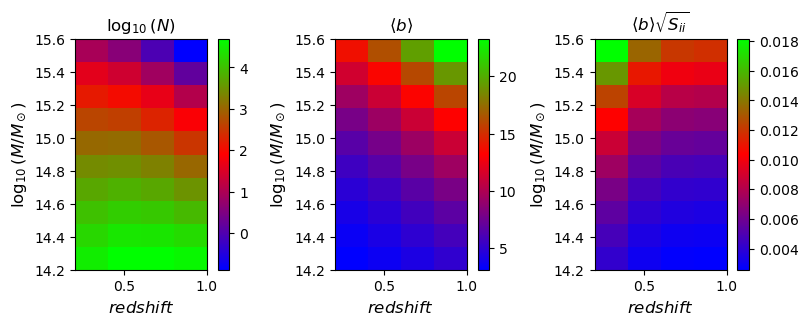

In [24]:
cmap = 'brg'
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(9.5,3))
plt.subplot(131)
#plt.text( 0.3, 15.4, r'$\frac{dn}{dm}\frac{d^2V}{dzd\Omega}$', color = 'w', fontsize=15)
plt.imshow(np.log10(Abundance.T), cmap=cmap, origin='lower', extent = (.2, 1, 14.2, 15.6))
plt.colorbar()
plt.title(r'$\log_{10}(N)$')
plt.xlabel(r'$redshift$', fontsize=12)
plt.ylabel(r'$\log_{10}(M/M_\odot)$', fontsize=12)
plt.subplot(132)
plt.imshow(Halo_bias.T, cmap=cmap, origin='lower', extent = (.2, 1, 14.2, 15.6))
plt.colorbar()
plt.title(r'$\langle b \rangle$')
plt.ylabel(r'$\log_{10}(M/M_\odot)$', fontsize=12)
plt.xlabel(r'$redshift$', fontsize=12)
plt.subplot(133)
plt.imshow(Sb.T, cmap=cmap, origin='lower', extent = (.2, 1, 14.2, 15.6))
plt.title(label=r'$\langle b \rangle \sqrt{S_{ii}}$')
plt.colorbar()
plt.ylabel(r'$\log_{10}(M/M_\odot)$', fontsize=12)
plt.xlabel(r'$redshift$', fontsize=12)
#plt.ylabel(r'$\log_{10}(M/M_\odot)$', fontsize=12)
#plt.savefig('halobias.png', bbox_inches='tight', dpi=300)
plt.savefig('mapping_binned.png', bbox_inches='tight', dpi=300)